In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Quantization noise
There is some amount of noise due to the digitization of the input signal by the ADC. Here the effect of a 1-bit offset is determined.  
The ADC uses 10 bits and operates at 3.3 V.  
For the tests, the 20 A version of the current sensor was used for the tests, defined in PowerSensor as MLX20.  
Default parameters were used: sensitivity (hereafter S) = 62.5 mV/A, Vref = 1.65 V.  
The voltage sensor was used directly and with a voltage divider of a factor 6.

In [2]:
# ADC resolution in V
voltage = 3.3
nbit = 10
adc_resolution = voltage / (2 ** nbit)
print(f'ADC resolution: {1000*adc_resolution:.4f} mV')

# current sensor
sensitivity = 62.5e-3  # V/A
current_resolution = adc_resolution / sensitivity
print(f'Current resolution: {1000*current_resolution:.4f} mA')

# voltage sensor: without voltage divider this is simply the ADC resolution
voltage_resolution_no_divider = adc_resolution
# with voltage divider the resolution decreases by the same factor as the divider
voltage_divider_factor = 6
voltage_resolution_with_divider = adc_resolution * voltage_divider_factor
print(f'Voltage resolution (no voltage divider): {1000*voltage_resolution_no_divider:.4f} mV')
print(f'Voltage resolution (with voltage divider): {1000*voltage_resolution_with_divider:.4f} mV')

# the power resolution is the product of the voltage and current resolutions
power_resolution_no_divider = current_resolution * voltage_resolution_no_divider
power_resolution_with_divider = current_resolution * voltage_resolution_with_divider
print(f'Power resolution (no voltage divider): {1000 * power_resolution_no_divider:.4f} mW')
print(f'Power resolution (with voltage divider): {1000 * power_resolution_with_divider:.4f} mW')

ADC resolution: 3.2227 mV
Current resolution: 51.5625 mA
Voltage resolution (no voltage divider): 3.2227 mV
Voltage resolution (with voltage divider): 19.3359 mV
Power resolution (no voltage divider): 0.1662 mW
Power resolution (with voltage divider): 0.9970 mW


### Sensor calibration
By comparing the measured current to the input current (and similarly for voltage sensors), the reference voltage and sensitivity calibration values can be measured.  
The proper values for S and Vref can be determined as follows:  

The equation for the measured current is:  $I_\mathrm{out} = \frac{V - V_\mathrm{ref}}{S}$  
The actual current ($I_\mathrm{in}$) is determined from the proper calibration values, denoted with an asterisk: $I_\mathrm{in} = \frac{V - V^*_\mathrm{ref}}{S^*}$  
If the calibration is already perfect, $I_\mathrm{out}$ is equal to $I_\mathrm{in}$. In reality it won't be, and we do a linear fit between these two to find the correct calibration values: $I_\mathrm{out} = a \times I_\mathrm{in} + b$  

Rewriting the equation for $I_\mathrm{out}$ to extract $V$ and putting in the result in the equation for $I_\mathrm{in}$, we can derive two equations for the correct calibration value in terms of the assumed values and the fit:  
$$
S^* = S \times a
\newline
V^*_\mathrm{ref} = S \times b + V_\mathrm{ref}
$$

The corrected $I_\mathrm{out}$ in terms of the assumed and correct calibration values is: $I_\mathrm{corr} = \frac{S \times I_\mathrm{out} + V_\mathrm{ref} - V^*_\mathrm{ref}}{S^*}$  

In [3]:
def load_data(fname):
    """
    Load a powersensor dumpfile

    returns nsensor, data
    """
    # get the number of sensors
    # the file contains 4 columns, plus 3 (current, voltage, power) for each sensor
    with open(fname, 'r') as fp:
        ncol = len(fp.readline().strip().split())
    nsensor = int((ncol - 4) / 3)
    
    column_names = ['S', 'time', 'delta_time_micro']
    for sensor in range(nsensor):
        column_names += [f'current{sensor}', f'voltage{sensor}', f'power{sensor}']
    column_names += ['power_total']
    # load the file, skip the last line as it may be incomplete (to be fixed in PowerSensor host library)
    # set comment character to M to ignore marked points
    return nsensor, np.genfromtxt(fname, skip_footer=1, names=column_names, comments='M')
    

def get_input_values(fname):
    """
    Get input voltage and current from dumpfile name
    Filename is assumed to be like 1.50V_2.00A.txt
    
    returns voltage, current
    """
    name = os.path.basename(fname)
    voltage = float(name.split('V')[0])
    current = float(name.split('_')[1].split('A')[0])
    return voltage, current


def get_statistics(data, sensor_id=0):
    """
    Obtain several statistics of the given dataset
    
    returns: dictionary with for each of voltage, current, power:
        mean, stddev, peak-to-peak
    """
    current = data[f'current{sensor_id}']
    voltage = data[f'voltage{sensor_id}']
    power = data[f'power{sensor_id}']
    stats = {'current': {'mean': current.mean(), 'stddev': current.std(), 'peak-to-peak': current.max() - current.min()},
             'voltage': {'mean': voltage.mean(), 'stddev': voltage.std(), 'peak-to-peak': voltage.max() - voltage.min()},
             'power': {'mean': power.mean(), 'stddev': power.std(), 'peak-to-peak': power.max() - power.min()}
            }
    return stats


def make_plot(xdata, ydata, xlabel, ylabel, title, yfit=None, ycorr=None, ax=None):
    """
    Make a figure of the given data
    
    returns: fig, ax (only if new figure is created)
    """
    # plot data sorted by input
    order = np.argsort(xdata)
    
    if ax is None:
        fig, ax = plt.subplots()
        return_vals = [fig, ax]
    else:
        return_vals = None
    ax.scatter(xdata[order], ydata[order], label='measured')
    ax.plot(xdata[order], xdata[order], c='r', ls='--', label='expected')
    if yfit is not None:
        ax.plot(xdata[order], yfit[order], label='fit')
    if ycorr is not None:
        ax.scatter(xdata[order], ycorr[order], c='g', label='corrected')
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return return_vals

Processing files (direct):   0%|          | 0/11 [00:00<?, ?it/s]

Results for direct
Noise statistics
Median relative noise, 3-sigma | peak-to-peak
Current: 9.78 % | 27.84 %
Voltage: 1.71 % | 6.25 %
Power: 9.87 % | 29.41 %

Calibration results
Current sensor, assumed | measured
Sensitivity (mV/A): 62.5000 | 62.1220
Vref (V): 1.6500 | 1.6420
Voltage sensor, assumed | measured
Sensitivity: 1.0000 | 1.0335
Vref (V): 0.0000 | -0.0531


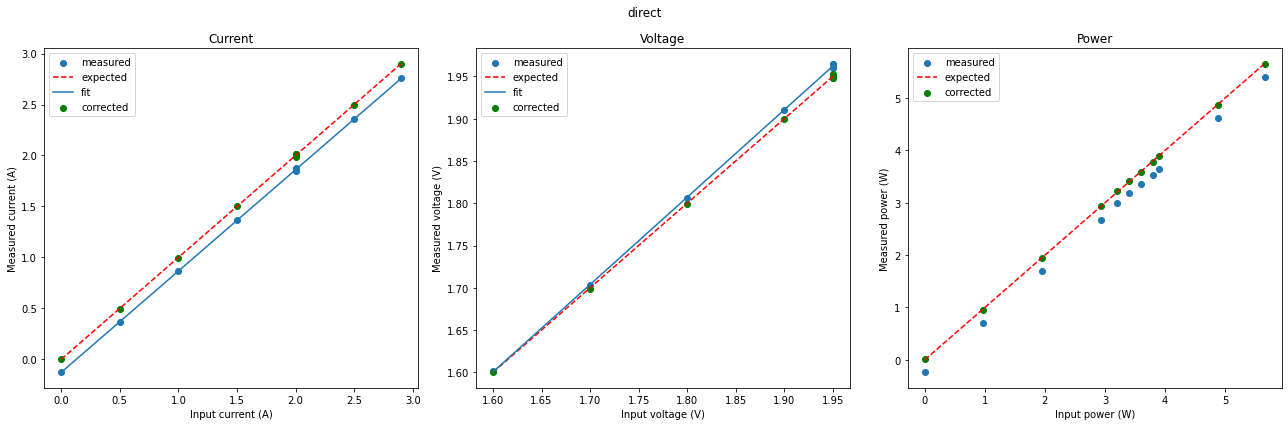

Processing files (current_only):   0%|          | 0/6 [00:00<?, ?it/s]

Results for current_only
Noise statistics
Median relative noise, 3-sigma | peak-to-peak
Current: 5.51 % | 16.09 %

Calibration results
Current sensor, assumed | measured
Sensitivity (mV/A): 62.5000 | 61.9860
Vref (V): 1.6500 | 1.6464


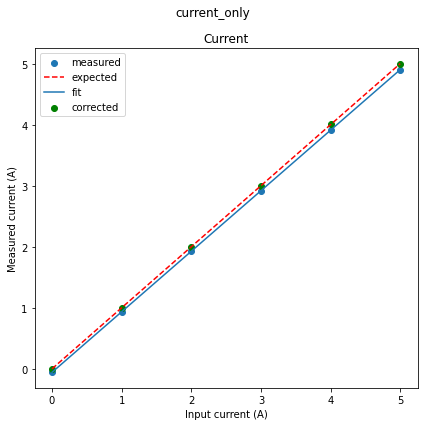

Processing files (voltage_divider):   0%|          | 0/8 [00:00<?, ?it/s]

Results for voltage_divider
Noise statistics
Median relative noise, 3-sigma | peak-to-peak
Voltage: 1.82 % | 6.23 %

Calibration results
Voltage sensor, assumed | measured
Sensitivity: 0.1667 | 0.1699
Vref (V): 0.0000 | -0.0390


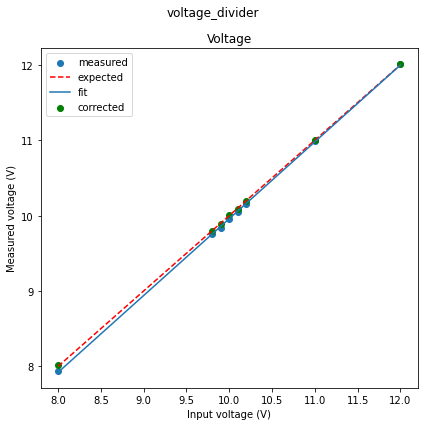

In [5]:
# do the calibration for these datasets
# 1. the direct measurement of voltage and current sensor output
# 2. measurements of the current sensor, where the voltage sensor was disconnected
# 3. voltage_divider, where both sensors were connected and a voltage divider was added to the voltage sensor to be able to measure 0-12 V (factor 6)

folders = ['direct', 'current_only', 'voltage_divider']
stat_keys = ['mean', 'stddev', 'peak-to-peak']

for folder in folders:
    files = glob.glob(f'data/{folder}/*.txt')
    num = len(files)
    Uin = np.zeros(num)
    Iin = np.zeros(num)
    Ustats = {}
    Istats = {}
    Pstats = {}
    for key in stat_keys:
        Ustats[key] = np.zeros(num)
        Istats[key] = np.zeros(num)
        Pstats[key] = np.zeros(num)
    
    for idx, fname in tqdm(enumerate(files), total=num, desc=f'Processing files ({folder})'):
        Uin[idx], Iin[idx] = get_input_values(fname)
        nsensor, data = load_data(fname)
        stats = get_statistics(data, sensor_id=0)
        for key in stat_keys:
            Ustats[key][idx] = stats['voltage'][key]
            Istats[key][idx] = stats['current'][key]
            Pstats[key][idx] = stats['power'][key]
        
    Pin = Uin * Iin
    
    # fit and plots, current only for direct and current_only
    # voltage only for direct and voltage_divider
    Vref_current = 1.65  # V
    sensitivity_current = 62.5e-3  # V/A
    Vref_voltage = 0  # V
    sensitivity_voltage = 1  # V/V
    match folder:
        case 'direct':
            nplot = 3
            plot_voltage = True
            plot_current = True
        case 'current_only':
            nplot = 1
            plot_voltage = False
            plot_current = True
        case 'voltage_divider':
            nplot = 1
            plot_voltage = True
            plot_current = False
            sensitivity_voltage = 1. / 6  # factor 6 voltage divider to measure up to 12 V in 0-2 V range
            
    # print statistics (only of sensors that were connected)
    noise_current_3sigma = 3 * Istats['stddev'] / Istats['mean']
    noise_voltage_3sigma = 3 * Ustats['stddev'] / Ustats['mean']
    noise_power_3sigma = 3 * Pstats['stddev'] / Pstats['mean']
    
    noise_current_peak = Istats['peak-to-peak'] / Istats['mean']
    noise_voltage_peak = Ustats['peak-to-peak'] / Ustats['mean']
    noise_power_peak = Pstats['peak-to-peak'] / Pstats['mean']
    
    print(f'Results for {folder} measurements')
    print('Median relative noise, 3-sigma | peak-to-peak')
    if plot_current:
        print(f'Current: {100 * np.median(noise_current_3sigma):.2f} % | {100 * np.median(noise_current_peak):.2f} %')
    if plot_voltage:
        print(f'Voltage: {100 * np.median(noise_voltage_3sigma):.2f} % | {100 * np.median(noise_voltage_peak):.2f} %')
    if plot_current and plot_voltage:
        print(f'Power: {100 * np.median(noise_power_3sigma):.2f} % | {100 * np.median(noise_power_peak):.2f} %')
    
    # create plots and fit the data to determine proper calibration values
    fig, axes = plt.subplots(ncols=nplot, figsize=(6 * nplot, 6), squeeze=False)
    axes = axes.flatten()
    ax_idx = 0
    
    print('\nCalibration results:')
    if plot_current:
        Islope, Ioffset = np.polyfit(Iin, Istats['mean'], deg=1)
        Ifit = Islope * Iin + Ioffset
        sensitivity_current_fit = sensitivity_current * Islope
        Vref_current_fit = sensitivity_current * Ioffset + Vref_current
        Icorr = (sensitivity_current * Istats['mean'] + Vref_current - Vref_current_fit) / sensitivity_current_fit
        print(f'Current sensor, assumed | measured')
        print(f'Sensitivity (mV/A): {sensitivity_current*1000:.4f} | {sensitivity_current_fit*1000:.4f}')
        print(f'Vref (V): {Vref_current:.4f} | {Vref_current_fit:.4f}')
        print()
        
        make_plot(Iin, Istats['mean'], 'Input current (A)', 'Measured current (A)', 'Current', yfit=Ifit, ycorr=Icorr, ax=axes[ax_idx])
        ax_idx += 1
        
    if plot_voltage:
        Uslope, Uoffset = np.polyfit(Uin, Ustats['mean'], deg=1)
        Ufit = Uslope * Uin + Uoffset
        sensitivity_voltage_fit = sensitivity_voltage * Uslope
        Vref_voltage_fit = sensitivity_voltage * Uoffset + Vref_voltage
        Ucorr = (sensitivity_voltage * Ustats['mean'] + Vref_voltage - Vref_voltage_fit) / sensitivity_voltage_fit
        print(f'Voltage sensor, assumed | measured')
        print(f'Sensitivity: {sensitivity_voltage:.4f} | {sensitivity_voltage_fit:.4f}')
        print(f'Vref (V): {Vref_voltage:.4f} | {Vref_voltage_fit:.4f}')
        
        make_plot(Uin, Ustats['mean'], 'Input voltage (V)', 'Measured voltage (V)', 'Voltage', yfit=Ufit, ycorr=Ucorr, ax=axes[ax_idx])
        ax_idx += 1

    if plot_current and plot_voltage:
        Pcorr = Icorr * Ucorr
        make_plot(Pin, Pstats['mean'], 'Input power (W)', 'Measured power (W)', 'Power', ycorr=Pcorr, ax=axes[ax_idx])

    fig.suptitle(folder)
    fig.tight_layout()
    plt.show(block=False)